In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Pre-processing & Exploratory Data Analysis (EDA)


### Sale Price
Quick check to see if distribution is normal or if we have to perform a transformation

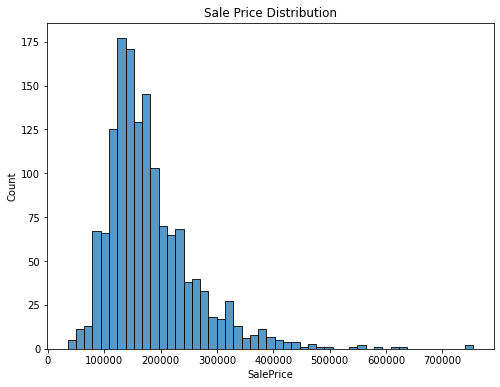

In [5]:
plt.figure(figsize=(8,6))
sns.histplot(train['SalePrice'])
title = plt.title("Sale Price Distribution")

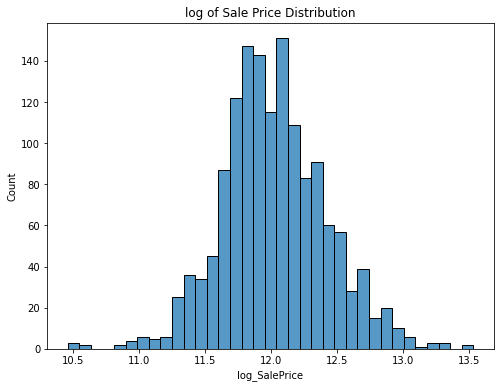

In [6]:
# We see that SalePrice is right-skewed, therefore we perform Log-Transformation
train['log_SalePrice'] = np.log(train['SalePrice'])

plt.figure(figsize=(8,6))
sns.histplot(train['log_SalePrice'])
title = plt.title("log of Sale Price Distribution")

## Correlation
Finding the 10 most correlated features

In [7]:
corr_mat = train.corr().SalePrice.sort_values(ascending=False)
# Added log_SalePrice, naturally will be more correlated
# 10 most correlated features
corr_mat.head(12)

SalePrice        1.000000
log_SalePrice    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
Name: SalePrice, dtype: float64

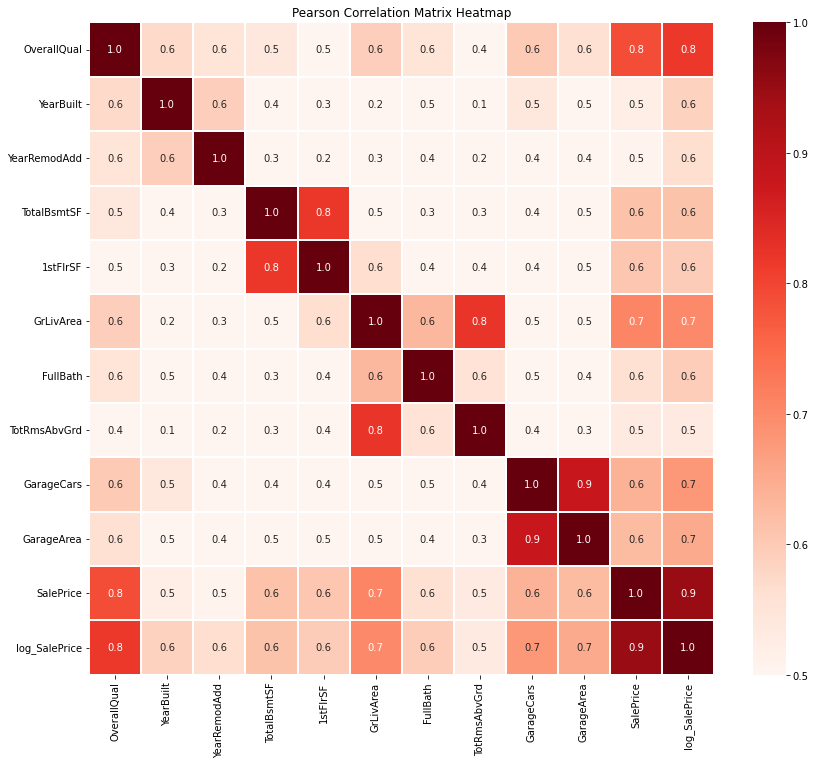

In [8]:
corr_train = train.corr()
highest_corr_features = corr_train.index[abs(corr_train['SalePrice']) > 0.5]

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation Matrix Heatmap', y=1)
sns.heatmap(train[highest_corr_features].corr(),
            annot = True,
            fmt ='.1f',
            linewidths=0.1,
            cmap='Reds',
            vmin = 0.5,
            vmax = 1,
            linecolor='white',
            )
plt.show()


There is multicolinearity, as expected. 
- GarageCars and GarageArea
- GarageYrBlt and YearBlt
- 1stFloorSf and TotalBsmtSF
- GrLivingArea and TotRmsAbvGrd

#### Overall Quality

Pretty clear that higher quality houses are more expensive

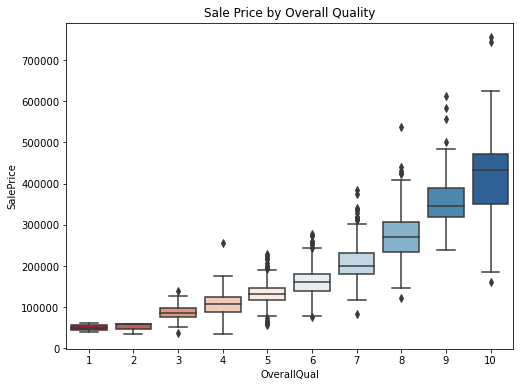

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x= 'OverallQual', y='SalePrice', data=train, palette='RdBu')
title = plt.title('Sale Price by Overall Quality')

#### Above Ground Living Area
Linear relationship, but has a few outliers (two houses in lower-right corner)

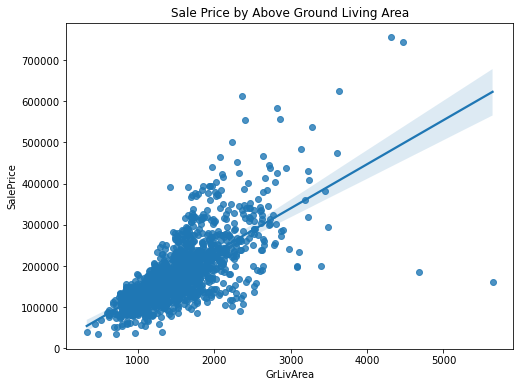

In [10]:
plt.figure(figsize=(8, 6))
sns.regplot(x= 'GrLivArea', y='SalePrice', data=train)
title = plt.title('Sale Price by Above Ground Living Area')

#### GarageCars

Houses with 4 car garages are cheaper than houses with only 3 car garages. 

GarageCars and GarageArea are highly correlated

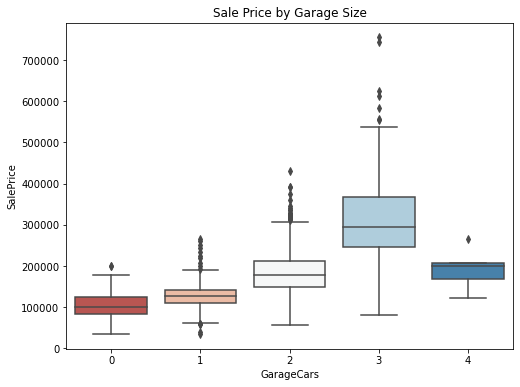

In [11]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train, palette='RdBu')
title = plt.title('Sale Price by Garage Size')

#### TottalBsmtSF

As one would assume, we do see a linear relationship. 

Again, like with GarageArea, I imagine features having to do with adding more square feet to a house will result in higher prices, so we will come back to those variables later.

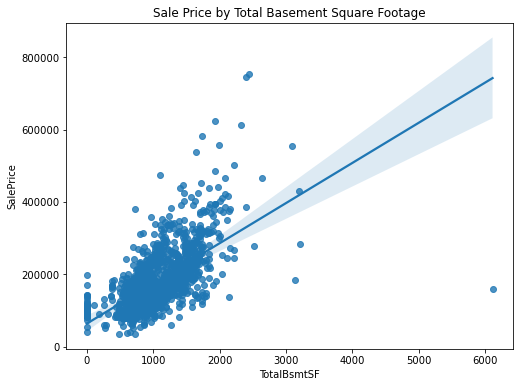

In [12]:
plt.figure(figsize=(8, 6))
sns.regplot(x= 'TotalBsmtSF', y='SalePrice', data=train)
title = plt.title('Sale Price by Total Basement Square Footage')

#### FullBath

Interestingly enough, Q3 for 0 full baths are more expensive than Q3 for 1 bath.

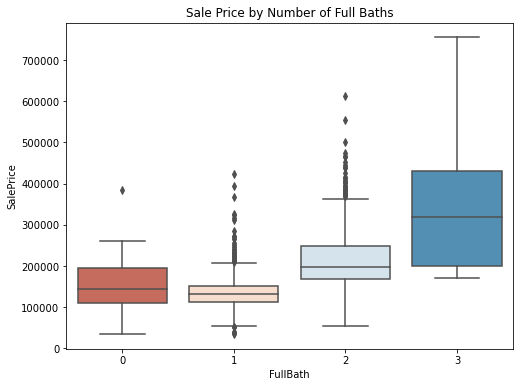

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='FullBath', y='SalePrice', data=train, palette='RdBu')
title = plt.title('Sale Price by Number of Full Baths')

#### YearBuilt

Newer houses have higher prices, although there are a few outliers.


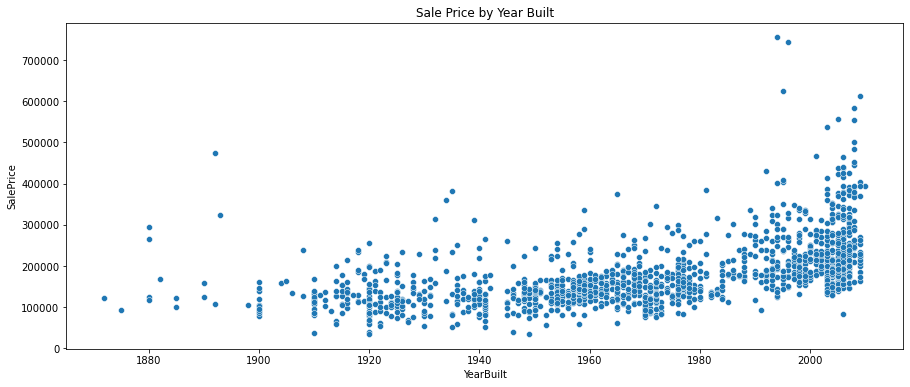

In [14]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train)
title = plt.title('Sale Price by Year Built')

#### Neighborhood
"Location, location, location"

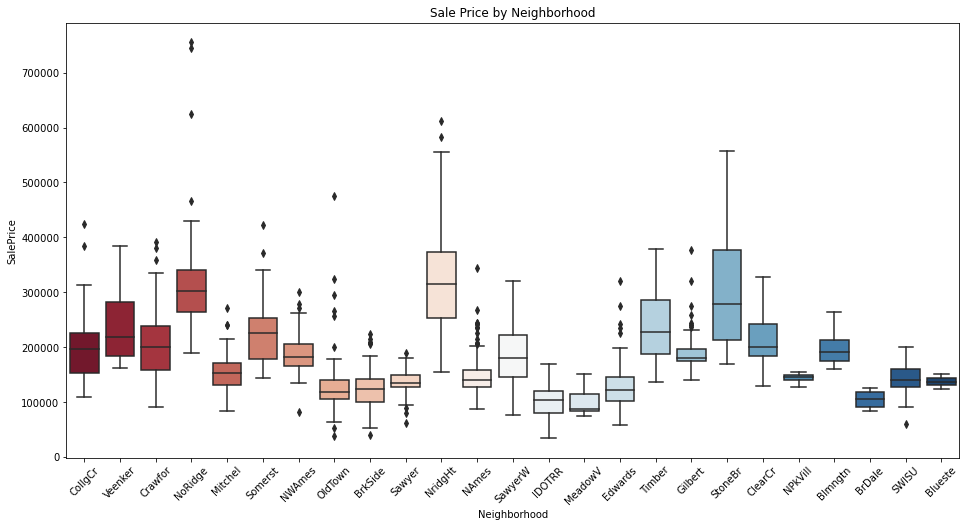

In [15]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train, palette='RdBu')
title = plt.title('Sale Price by Neighborhood')
tick = plt.xticks(rotation=45)

## Variables that will require further examination:

#### Continuous:
- LotFrontage

#### Discrete:
- GarageYrBlt

#### Ordinal:
- BsmtQual 
- BsmtCond 
- BsmtExposure 
- BsmtFinType1 
- BsmtFinType2
- Electrical
- FireplaceQu
- GarageQual
- GarageCond
- PoolQC
- Fence

#### Nominal:
- Alley 
- MasVnrType
- MasVnrArea
- GarageType
- GarageFinish
- MiscFeature


## Continuous Variable Editing

#### Lot Frontage

In [16]:
# LotFrontage is the linear feat of street connected to property

train[train['LotFrontage'].isnull() == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_SalePrice
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,12.206073
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,144000,11.877569
14,15,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,...,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000,11.964001
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Shed,700,3,2010,WD,Normal,149000,11.911702
24,25,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000,11.944708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430,20,RL,NaN,12546,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2007,WD,Normal,182900,12.116695
1431,1432,120,RL,NaN,4928,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,10,2009,WD,Normal,143750,11.875831
1441,1442,120,RM,NaN,4426,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2008,WD,Normal,149300,11.913713
1443,1444,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2009,WD,Normal,121000,11.703546


In [17]:
# We can change the missing LotFrontage rows to the median of LotFrontage of
# the neighborhood its in

neighborhood_medians = train.groupby('Neighborhood')['LotFrontage'].median()
neighborhood_medians = neighborhood_medians.fillna(np.median(neighborhood_medians))

In [18]:
neighborhood_medians.head()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    52.0
ClearCr    80.0
Name: LotFrontage, dtype: float64

In [19]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['Neighborhood'])
train['LotFrontage'] = train['LotFrontage'].map(lambda x: neighborhood_medians[x] if type(x)==str else x)


In [20]:
train['LotFrontage'].isna().sum()

0

#### Masonry

In [21]:
# There's not too many missing values
train['MasVnrArea'].isna().sum()

train.loc[(train['MasVnrArea'].isnull()),'MasVnrArea']= 0.0

## Discrete Variable Editing

In [22]:
# GarageYrBlt
# I am making the assumption that most garages were built at the same time 
# the house was.

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])

# print(train['GarageYrBlt'].isna().sum())


## Ordinal Variables Editing

In [23]:
# BsmtQual, FireplaceQu, and GarageQual all have the same metric
# Ex = Excellent, Gd = Good, TA = average, FA = Fair, Po = Poor, NA = No 'Feature'

#### Basement
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2

In [24]:
# NA means No Basement
train.loc[(train['BsmtQual'].isna()), 'BsmtQual'] = 'NoBasement'
train.loc[(train['BsmtCond'].isna()), 'BsmtCond'] = 'NoBasement'
train.loc[(train['BsmtExposure'].isna()), 'BsmtExposure'] = 'NoBasement'
train.loc[(train['BsmtFinType1'].isna()), 'BsmtFinType1'] = 'NoBasement'
train.loc[(train['BsmtFinType2'].isna()), 'BsmtFinType2'] = 'NoBasement'

print(train['BsmtQual'].unique())
# print(train['BsmtQual'].isna().sum())

print(train['BsmtCond'].unique())
# print(train['BsmtCond'].isna().sum())

print(train['BsmtExposure'].unique())
# print(train['BsmtExposure'].isna().sum())

print(train['BsmtFinType1'].unique())
# print(train['BsmtFinType1'].isna().sum())

print(train['BsmtFinType2'].unique())
# print(train['BsmtFinType2'].isna().sum())

['Gd' 'TA' 'Ex' 'NoBasement' 'Fa']
['TA' 'Gd' 'NoBasement' 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' 'NoBasement']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NoBasement' 'LwQ']
['Unf' 'BLQ' 'NoBasement' 'ALQ' 'Rec' 'LwQ' 'GLQ']


#### Electrical

In [25]:
# Electrical is missing 1 value; we can just leave it.
np.where(train['Electrical'].isna())

(array([1379]),)

#### Fireplace

In [26]:
train.loc[(train['FireplaceQu'].isna()), 'FireplaceQu'] = 'NoFireplace'
print(train['FireplaceQu'].unique())

train['FireplaceQu'].isna().sum()

['NoFireplace' 'TA' 'Gd' 'Fa' 'Ex' 'Po']


0

#### Garage
- GarageQual
- GarageCond

In [27]:
# NA = No Garage 
train.loc[(train['GarageQual'].isna()), 'GarageQual'] = 'NoGarage'
print(train['GarageQual'].unique())
# print(train['GarageQual'].isna().sum())


train.loc[(train['GarageCond'].isna()), 'GarageCond'] = 'NoGarage'
print(train['GarageCond'].unique())
# print(train['GarageCond'].isna().sum())




['TA' 'Fa' 'Gd' 'NoGarage' 'Ex' 'Po']
['TA' 'Fa' 'NoGarage' 'Gd' 'Po' 'Ex']


#### Pool


In [28]:
# Similarly, na values for Pool mean there is no pool
train.loc[(train['PoolQC'].isna()), 'PoolQC'] = 'NoPool'
print(train['PoolQC'].unique())

train['PoolQC'].isna().sum()

['NoPool' 'Ex' 'Fa' 'Gd']


0

#### Fence

In [29]:
# NA values for Fence mean no fence.
train.loc[(train['Fence'].isna()), 'Fence'] = 'NoFence'
print(train['Fence'].unique())

train['Fence'].isna().sum()

['NoFence' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


0

## Nominal Variables Editing

#### Alley

In [30]:
train.loc[(train['Alley'].isna()),'Alley']= 'NoAlley'
print(train['Alley'].unique())

print(train['Alley'].isna().sum())

['NoAlley' 'Grvl' 'Pave']
0


#### Masonry


In [31]:
train.loc[(train['MasVnrArea'].isnull()),'MasVnrType']='NoMas'
print(train['Alley'].unique())

print(train['Alley'].isna().sum())

['NoAlley' 'Grvl' 'Pave']
0


In [32]:
train.to_csv('train_clean.csv', index=False)